In [3]:
from scipy import integrate, optimize
from scipy.optimize import minimize
from scipy.optimize import basinhopping
import matplotlib.pyplot as plt
import numpy as np
import random
import math

In [53]:
if __name__ == "__main__":
    N = 25000
    ALPHA = 0.04
    p_alpha = 0.75 ## this is always > ALPHA    
    
    
    
    def Shaman(y, x, alpha, beta, mu):
        alpha = (1-alpha)/alpha * alpha
        
#         dS = -1.0*beta*y[0]*(y[2]+y[3])/N
#         dE = beta*y[0]*(y[2]+y[3])/N - alpha_r*y[1] - alpha_u*y[1]
#         dI_r = alpha_r*y[1] - gamma_r*y[2] - mu*y[2]
#         dI_u = alpha_u*y[1] - gamma_u*y[3]
#         dR = gamma_r*y[2] + gamma_u*y[3]
#         dM = mu*y[2]
        
        S, E, Ir, Iu = y[0], y[1], y[2], y[3]

        #M = sum(mobility)

        Z = 5 #average latency period

        D = 10 #average duration of infection


        
        
        dS = -beta*S*Ir/N - mu*beta*S*Iu/N #+theta * M* S/ (N-Ir)


        dE = beta*S*Ir/N + mu*beta*S*Iu/N - E/Z #+ theta*M*E / (N)
      
  
        dI_r = alpha*E/Z - Ir/D
    
        
        dI_u = (1-alpha)* E/Z - Iu/D
  
  
  
        return dS, dE, dI_r, dI_u #, dR, dM

  
  
  
  
  
    def FitShaman(x, alpha,beta, mu, E0):        
        S0 = N - E0
        
        ret =  integrate.odeint(func = Shaman, y0 = (S0, E0, 0, 0), t = x, args = (alpha, beta, mu))

        I = N - ret[:,0] - ret[:,1]
        Ir = alpha*np.gradient(I)
        Iu = (1-alpha) * np.gradient(I)
        
#         M = ret[:,5]
#         M = 10*np.gradient(M)
#         IM = np.hstack((Ir,M))
        
        return np.hstack((Ir,Iu))

      
      
    def FitShaman_p(x, alpha, beta,  mu, E0):
        
        S0 = N - E0
        
        ret =  integrate.odeint(func = Shaman, y0 = (S0, E0, 0, 0), t = x, args = (p_alpha,  beta, mu))

        I = N - ret[:,0] - ret[:,1]
        Ir = p_alpha*np.gradient(I)
        Iu = (1-alpha) * np.gradient(I)
        
#         M = ret[:,5]
#         M = 10*np.gradient(M)
#         IM = np.hstack((Ir,M))
        
        return np.hstack((Ir,Iu))

  
  
  
    def FitShaman_pp(x, alpha, beta,  mu, E0): 
        S0 = N - E0
        
        ret =  integrate.odeint(func = Shaman, y0 = (S0, E0, 0, 0), t = x, args = (alpha,  beta, mu))
        
        I = N - ret[:,0] - ret[:,1]
        I = np.gradient(I)
        Ir = alpha*I
        Iu = (1-alpha)*I

        return np.hstack((Ir,Iu))

    XData = list(range(1, 90+1))
    XData = np.array(XData, dtype = float)
    
    Data = integrate.odeint(func = Shaman, y0 = (N-10, 10, 0, 0), t = XData, args = (ALPHA,  0.36, 0.005)) # Ground truth alpha
    '''
    figure = plt.figure(figsize = (10.24, 7.68))
    plt.plot(Data[:,0], label = 'S')
    plt.plot(Data[:,1], label = 'E')
    plt.plot(Data[:,2], label = 'I_r')
    plt.plot(Data[:,3], label = 'I_u')
    plt.plot(Data[:,4], label = 'R')
    plt.plot(Data[:,5], label = 'M')
    plt.legend()
    plt.show()
    '''   
    YCases = N - Data[:,0] - Data[:,1]
    YCases = np.gradient(YCases)
    YReports = ALPHA*YCases
    YUnreports = (1-ALPHA)*YCases
#     YDeaths = Data[:,5]
#     YDeaths = 10*np.gradient(YDeaths)

    YData = np.hstack((YReports, YUnreports))
    YData = np.array(YData, dtype = float)

    ParaOpt_p, ParaCov_p = optimize.curve_fit(f = FitShaman_p, xdata = XData, ydata = YData, maxfev = 10000, p0 = ( 1, 1, 1, 10), bounds = [[0,0,0,0], [1,1,1,N]])
    '''
    print('p:')
    print('report rate:',0.75)
    print('alpha_reported:',ParaOpt_p[0])
    print('alpha_unreported:',ParaOpt_p[0]*(1-0.75)/0.75)
    print('beta:',ParaOpt_p[1])
    print('gamma_reported:',ParaOpt_p[2])
    print('gamma_unreported:',ParaOpt_p[3])
    print('mu:',ParaOpt_p[4])
    print('S0:',N-ParaOpt_p[5])
    print('E0:',ParaOpt_p[5])
    print('Iu0:',0)
    print('Ir0:',0)
    print('R0:',0)
    print('M0:',0)
    '''
    Parameter_p = [p_alpha, ParaOpt_p[0], ParaOpt_p[1], ParaOpt_p[2]]

    Result_p = FitShaman(XData, *Parameter_p)
    '''    
    figure = plt.figure(figsize = (15.36,3.84))
    plt.subplot(1,3,1)
    plt.plot(XData, YReports, label='D_reported')
    plt.plot(XData, Result_p[:len(YCases)], label='D_OS_reported(p)')
    plt.xlabel('Time')
    plt.ylabel('Cases')
    plt.title("p -> Calibrate(OS, D_reported)")
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(XData, YDeaths, label='D_mortality')
    plt.plot(XData, Result_p[len(YCases):], label='D_OS_mortality(p)')
    plt.xlabel('Time')
    plt.ylabel('Cases')
    plt.title("p -> Calibrate(OS, D_reported)")
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(XData, YCases, label='D_ground_truth')
    plt.plot(XData, Result_p[:len(YCases)]/Parameter_p[0], label='D_OS(p)')
    plt.xlabel('Time')
    plt.ylabel('Cases')
    plt.title("p -> Calibrate(OS, D_reported)")
    plt.legend()
    plt.show()
    '''
    def IntegerCost(x):
        Sum = math.log(2.865,2)+1
        if (abs(x) > 1.01):
            add = math.log(abs(x),2)
            while (add > 1.01):
                Sum = Sum + add
                add = math.log(add,2)
        return Sum

    def RealNumberCost(x):
        delta = 0.1
        if (math.floor(abs(x)) == 0):
            return 1-math.log(delta,2) 
        else:
            return IntegerCost(math.floor(abs(x)))-math.log(delta,2)+1 

    def VectorCost(x):
        Sum = 0
        for xnow in x:
            Sum = Sum + RealNumberCost(xnow)
        return Sum
    
    def TimeSeriesCost(x):
        Sum = 0
        Length = x.shape[0]
        x_grad = np.around(np.gradient(x))
        T, Tcount = np.unique(x_grad, return_counts = True)
        XDictionary = {}
        for counter in range(len(T)):
            XDictionary[int(T[counter])] = int(Tcount[counter]) 
        for keys in XDictionary.keys():
            Sum = Sum + 1.0*XDictionary[keys]/Length*math.log(1.0*Length/XDictionary[keys],2)
        Sum = Length * Sum
        for keys in XDictionary.keys():
            Sum = Sum + IntegerCost(int(keys))
        return Sum

    def MDL(D, Parameter_p):
#         print (D)
        
        YDataMore = np.hstack((YReports, D-YReports))
        ParaOpt_pp, ParaCov_pp = optimize.curve_fit(f = FitShaman_pp, xdata = XData, ydata = YDataMore, maxfev = 100000, p0 = ( 1, 1, 1, 10), bounds = [[0,0,0,0], [1,1,1,N]])
        Parameter_pp = [ParaOpt_pp[0], ParaOpt_pp[1], ParaOpt_pp[2], ParaOpt_pp[3]]
        Result_pp = FitShaman_pp(XData, *Parameter_pp)

        Parameter_p = np.array(Parameter_p)
        Parameter_pp = np.array(Parameter_pp)
        
        ModelCost1 = VectorCost(Parameter_p)
        ModelCost2 = VectorCost(Parameter_pp - Parameter_p)
        ModelCost3 = TimeSeriesCost(Parameter_pp[0]*D - Result_p[:len(YCases)])
        ModelCost = ModelCost1 + ModelCost2 + ModelCost3
        DataCost = TimeSeriesCost((D-YReports)/(1-Parameter_pp[0]) - (Result_pp[:len(YCases)]+Result_pp[len(YCases):2*len(YCases)]))
        MDLCost = ModelCost + DataCost
        
        Loss = MDLCost

        
        
#         print(Loss)
        return Loss

      
      
    def MDL_alpha(alpha, Parameter_p):
#         print (D)
        
        D = YReports/alpha
  
        YDataMore = np.hstack((YReports, D-YReports))
        ParaOpt_pp, ParaCov_pp = optimize.curve_fit(f = FitShaman_pp, xdata = XData, ydata = YDataMore, maxfev = 100000, p0 = (1, 1, 1, 10), bounds = [[0,0,0,0], [1,1,1,N]])
        Parameter_pp = [ParaOpt_pp[0], ParaOpt_pp[1], ParaOpt_pp[2]]
        Result_pp = FitShaman_pp(XData, *Parameter_pp)

        Parameter_p = np.array(Parameter_p)
        Parameter_pp = np.array(Parameter_pp)
        
        ModelCost1 = VectorCost(Parameter_p)
        ModelCost2 = VectorCost(Parameter_pp - Parameter_p)
        ModelCost3 = TimeSeriesCost(Parameter_pp[0]*D - Result_p[:len(YCases)])
        ModelCost = ModelCost1 + ModelCost2 + ModelCost3
        DataCost = TimeSeriesCost((D-YReports)/(1-Parameter_pp[0]) - (Result_pp[:len(YCases)]+Result_pp[len(YCases):2*len(YCases)]))
        MDLCost = ModelCost + DataCost
        
        Loss = MDLCost

        return Loss

In [54]:
# mdlcost = float('inf')
# alpha_hat = 0
# for a in np.arange(0.01, 0.9, 0.01):
#   c = MDL_alpha(a, Parameter_p)
#   if( c < mdlcost):
#     mdlcost = c
#     alpha_hat = a

# print(mdlcost)
# print(alpha_hat)

In [55]:
D_start = np.copy(YReports) / 0.5


res = minimize(fun=MDL, x0=D_start, args=(Parameter_p), method='nelder-mead', options={'adaptive': True})


D = res.x

MDLCost = MDL(D, Parameter_p)
Measure = (np.linalg.norm(D-YCases)/np.linalg.norm(YCases))


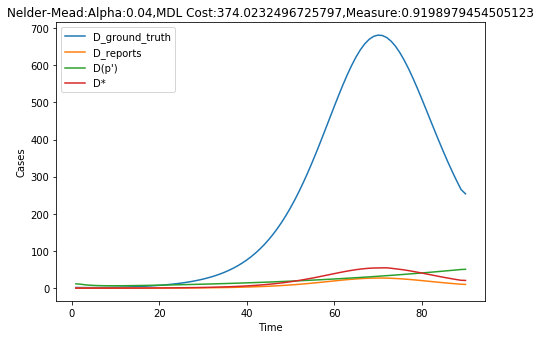

In [56]:
YDataMore = np.hstack((YReports, D-YReports))
ParaOpt_pp, ParaCov_pp = optimize.curve_fit(f = FitShaman_pp, xdata = XData, ydata = YDataMore, maxfev = 100000, p0 = (1, 1, 1, 10), bounds = [[0,0,0,0], [1,1,1,N]])
Parameter_pp = [ParaOpt_pp[0], ParaOpt_pp[1], ParaOpt_pp[2], ParaOpt_pp[3]]
Result_pp = FitShaman_pp(XData, *Parameter_pp)

figure = plt.figure(figsize = (7.68,5.12))
plt.plot(XData, YCases, label='D_ground_truth')
plt.plot(XData, YReports, label='D_reports')
plt.plot(XData, (Result_pp[:len(YCases)]+Result_pp[len(YCases):2*len(YCases)]), label='D(p\')')
plt.plot(XData, D, label='D*')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.title("Nelder-Mead:Alpha:" + str(ALPHA) + ",MDL Cost:" + str(MDLCost) + ",Measure:" + str(Measure))
plt.legend()
plt.show()

In [48]:
Measure

0.9199999999999998

In [ ]:
ms = [0.98, 0.24999902898669524, 0.074, 0.125, 0.09999999999999999, 0.0, 0.08333333333333323, 0.0714285714285715, 0.057142857142856995
, 0.062499999999999896]
alphas = [0.015, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.74, 0.85]

plt.plot(alphas, ms)
plt.ylabel(r'$\frac{| D^* - D_{gt}|} {D_{gt}}$')
plt.xlabel(r'$\alpha_{gt}$')